# Matrix multiplication from foundations

**Jupyter notebook can be used for libraries.**


In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
#export
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

- To run tests in console:
- ! python run_notebook.py 01_matmul.ipynb

#### Export
- !./notebook2script.py 00_exports.ipynb
- Converted 00_exports.ipynb to nb_00.py file which will contain #export marked cells

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import fastai

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [0]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))

n, c = x_train.shape

x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
img = x_train[0]

In [0]:
img.view(28, 28).type()

'torch.FloatTensor'

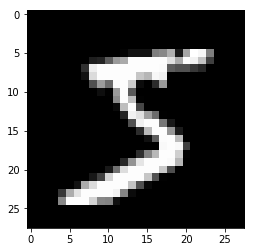

In [0]:
plt.imshow(img.view(28,28));

## Initial Python Model

Linear model: **y = ax + b**

a = weights
b = bias

In [0]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [0]:
m1 = x_valid[:5]
m2 = weights

In [0]:

m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [0]:
%time t1=matmul(m1, m2)

CPU times: user 679 ms, sys: 249 µs, total: 679 ms
Wall time: 679 ms


In [0]:
t1.shape

torch.Size([5, 10])

- This version is although slow and there is a technique to speed it up by 50,000 time. The reason why this is so slow is that we are using pure Python. We want to use PyTorch because it is using C.

     **Elementwise Ops**

    Operators (+,-,*,/,>,<,==) are usually element-wise.

    Examples of element-wise operations:

In [82]:
len(x_train)

50000

In [0]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [0]:
a + b

tensor([12., 14.,  3.])

In [0]:
(a<b).float().mean()

tensor(0.6667)

In [0]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]])
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
(m*m).sum().sqrt()

tensor(16.8819)

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

- This is the same thing as previously but now we calculate the whole row/column at a time. This is 178 times faster.

In [0]:
%timeit -n 10 _=matmul(m1, m2)

10 loops, best of 3: 1.2 ms per loop


- We have now 178 times faster code than we started but there is still for loops created with Python we need to get rid of. We can eliminate the j loop by using broadcasting.

**Broadcasting**

Broadcasting means that numbers are copied so that the shape of tensor change to something else we need. For example when a is tensor of ones and we do a>0 it mean the same as [1,1,1]>[0,0,0] As you can see zeros are broadcasted to one by three tensor. We can see the broadcasted version using expand_as method in PyTorch.

- Broadcasting with a scalar

In [83]:
a

tensor([10.,  6., -4.])

In [84]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

- How are we able to do a > 0? 0 is being broadcast to have the same dimensions as a.

- We can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

In [85]:
a + 1

tensor([11.,  7., -3.])

In [86]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [87]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

- Broadcasting a vector to a matrix

In [88]:
c = tensor([10.,20,30])
c

tensor([10., 20., 30.])

In [89]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [90]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [91]:
c.expand_as(m)

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [92]:
m+c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [93]:
c+m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [0]:
t = c.expand_as(m)

In [95]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [96]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [97]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [98]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [99]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [100]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [101]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [102]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [0]:
c.shape, c[None].shape, c[:, None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

- You can always skip trailling ':'s. And '...' means 'all preceding dimensions'

In [0]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [0]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [0]:
m+c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [0]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

### Matmul with broadcasting

In [0]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i]   = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [104]:
%timeit -n 10 _=matmul(m1, m2)

10 loops, best of 3: 244 µs per loop


- This code is 3,195 times faster than pure Python code.

In [105]:
c[None,:]

tensor([[10., 20., 30.]])

In [106]:
c[None,:].shape

torch.Size([1, 3])

In [107]:
c[:, None]

tensor([[10.],
        [20.],
        [30.]])

In [108]:
c[:, None].shape

torch.Size([3, 1])

In [109]:
c[None, :] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [110]:
c[None] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

In [111]:
c[None].shape

torch.Size([1, 3])

In [112]:
c.shape

torch.Size([3])

### Einstein summation

How to make Einstein summation notation

The left side of the arrow is output and the right side of the arrow is input. All inputs are separated by a comma. The number of letters in input tells how many ranks there are. For example, ik means that there are 2 ranks. Letters represent length of that dimension. When we have two same letters in two different inputs it means that we calculate dot product over those dimensions.

In [0]:
def matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

In [0]:
%timeit -n 10 _=matmul(m1, m2)

The slowest run took 90.49 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 30.4 µs per loop


- This is the new matmul function. It is 16,000 faster than the original pure Python code.

## Pytorch Operations

- We can use pytorch's function or operator directly for matrix multiplication.

In [0]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 62.38 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 8.01 µs per loop


In [0]:
t2 = m1@m2

In [0]:
m1.shape, m2.shape, t2.shape

(torch.Size([5, 784]), torch.Size([784, 10]), torch.Size([5, 10]))

In [0]:
m3, m4 = m1.cuda(), m2.cuda()

In [0]:
t3 = m3.matmul(m4)

In [0]:
%timeit -n 10 t3 = m3.matmul(m4)

10 loops, best of 3: 14.6 µs per loop


- This is the best code for this problem we can create using current tools in Python. It is 50,000 times faster than the original code. The reason that this is much faster than einsum is that matmul is designed to calculate one bit at a time which means that numbers don’t need to get from RAM many times. These is done using low-level programming languages.